In [198]:
import os
import time

from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

from torchvision import transforms

import matplotlib.pyplot as plt

from parse import parse

In [199]:
required_training = True

# CNN Model Architecture

In [200]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            
            # In = 64,64
            nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3, bias = False, padding = 1),
            nn.BatchNorm2d(6),
            nn.ReLU(inplace = True),

            nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 3, bias = False, padding = 1),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace = True),

            nn.MaxPool2d(kernel_size = 2),
            # Out = 32, 32


            # In = 32, 32
            nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = 3, bias = False, padding = 1),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace = True),

            nn.Conv2d(in_channels = 24, out_channels = 48, kernel_size = 3, bias = False, padding = 1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace = True),

            nn.MaxPool2d(kernel_size = 2),
            #  Out = 16, 16
            

            # In = 16,16
            nn.Conv2d(in_channels = 48, out_channels = 96, kernel_size = 3, bias = False, padding = 1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace = True),

            nn.Conv2d(in_channels = 96, out_channels = 144, kernel_size = 3, bias = False, padding = 1),
            nn.BatchNorm2d(144),
            nn.ReLU(inplace = True),

            nn.MaxPool2d(kernel_size = 2),
            #  Out = 8, 8

            # In = 8, 8
            nn.Conv2d(in_channels = 144, out_channels = 216, kernel_size = 3, bias = False, padding = 1),
            nn.BatchNorm2d(216),
            nn.ReLU(inplace = True),

            nn.Conv2d(in_channels = 216, out_channels = 324, kernel_size = 3, bias = False, padding = 1),
            nn.BatchNorm2d(324),
            nn.ReLU(inplace = True),

            nn.MaxPool2d(kernel_size = 2),
            # Out = 4, 4
        )

        # Fully connected layers
        self._head = nn.Sequential(
            # First fully connected layer
            # in_features = total number of weights in last conv layer = 16 * 5 * 5
            # nn.Linear(in_features=18 * 14 * 14, out_features=120), 
            nn.Linear(in_features=324 * 4 * 4, out_features=432), 

            # ReLU activation
            nn.ReLU(inplace=True),

            # second fully connected layer
            # in_features = output of last linear layer = 120 
            nn.Linear(in_features=432, out_features=144), 

            # ReLU activation
            nn.ReLU(inplace=True),

            # third fully connected layer
            nn.Linear(in_features=144, out_features=72), 

            # ReLU activation
            nn.ReLU(inplace=True),

            # Third fully connected layer
            nn.Linear(in_features=72, out_features=2)

        )
        
    def forward(self, x):
        # apply feature extractor
        x = self._body(x)
        
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weight_in_last conv_layer
        x = x.view(x.size()[0], -1)

        x = self._head(x)

        return x

## Display The Network

In [201]:
# 2) DISPLAY THE NETWORK
my_model = MyModel()
print(my_model)

# for index, layer in enumerate(my_model.features):
#     filter = layer.weight.data.clone()

MyModel(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

# Get Data

In [202]:
class FacesDataset(Dataset):
    def __init__(self, predict = 'train', transform = None):
        """
        init method of the class.

        Parameters:

        predict (string): whether to get train, val, or test data
        transform (method): method that will take PIL image and transform it.

        """
        # initialize the data dictionary
        self.data_dict = {
            'image': [],
            'label': []
        }

        if predict.lower() == 'train':
            images, labels = parse('facedata/facedatatrain', 'facedata/facedatatrainlabels', False)
            self.data_dict['label'] = torch.tensor(labels).long()
            self.data_dict['image'] = torch.tensor(np.expand_dims(images, axis=1)).float().cuda()

        elif predict.lower() == 'val':
            images, labels = parse('facedata/facedatavalidation', 'facedata/facedatavalidationlabels', False)
            self.data_dict['label'] = torch.tensor(labels).long()
            self.data_dict['image'] = torch.tensor(np.expand_dims(images, axis=1)).float().cuda()

        elif predict.lower() == 'test':
            images, labels = parse('facedata/facedatatest', 'facedata/facedatatestlabels', False)
            self.data_dict['label'] = torch.tensor(labels).long()
            self.data_dict['image'] = torch.tensor(np.expand_dims(images, axis=1)).float().cuda()
            
        self.classes = np.array(["Not Face", "Face"])

        self.transform = transform
        self.predict = predict

    def __len__(self):
        """
        return length of the dataset
        """
        return len(self.data_dict['image'])


    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing.
        """
        # breakpoint()
        image = self.data_dict['image'][idx]
        # breakpoint()
        if self.transform:
            image = self.transform(image)
        target = self.data_dict['label'][idx]
        return image, target

    def name(self, label):
        """
        class label to common name mapping
        """

        return self.classes[label]


In [203]:
def get_data(batch_size, val = True, transform = None, num_workers=1):
        
    if transform:
        transform = transforms.Compose([
            # this re-scale image tensor values between 0-1. image_tensor /= 255
            transforms.Resize(64),
            # subtract mean and divide by variance.
            # transforms.Normalize(mean, std)
        ])
    else:
        transform = None
    
    train_dataset =  FacesDataset('train', transform)
    if val:
        test_dataset =  FacesDataset('val', transform)
    else:
        test_dataset =  FacesDataset('test', transform)

    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=15,
        shuffle=True,
    )
 
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=15,
        shuffle=True,
    )
        
    return train_loader, test_loader

## System Configuration

In [204]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)


## Training Configuration

In [205]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32 # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 10  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.001  # determines the speed of network's weights update
        
    log_interval: int = 100  # how many batches to wait between logging training status
    test_interval: int = 1 # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "../resource/lib/publicdata/images"  # folder to save data
    val: bool = True
    num_workers: int = 10  # number of concurrent processes using to prepare data
    device: str = 'cuda'  # device to use for training.
    # update changed parameters in below coding block.
    # Please do not change "data_root" 
    
    # learning_rate = 0.001
    # test_interval = 1
    # batch_size = 64
    # epochs_count = 2

## System Setup

In [206]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

# Training

In [221]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad(set_to_none=True)
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
            print(
                f'Train Epoch: {epoch_idx} [{batch_idx * len(data)}/{len(train_loader.dataset)}]' +' Loss: {:.6f} Acc: {:.4f}'.format(
                    loss.item(), acc
                )
            )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc


# Validation

In [222]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    model.eval()
    test_loss = 0
    count_corect_predictions = 0

    with torch.no_grad():

        for data, target in test_loader:
            indx_target = target.clone()
            data = data.to(train_config.device)
            
            target = target.to(train_config.device)
            
            output = model(data)
            # add loss for each mini batch
            test_loss += F.cross_entropy(output, target).item()
            
            # Score to probability using softmax
            prob = F.softmax(output, dim=1)
            
            # get the index of the max probability
            pred = prob.data.max(dim=1)[1] 
            
            # add correct prediction count
            count_corect_predictions += pred.cpu().eq(indx_target).sum()

        # average over number of mini-batches
        test_loss = test_loss / len(test_loader)  
        
        # average over number of dataset
        accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
        
        print(
            '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
            )
        )

    return test_loss, accuracy/100.0

## Saving The Model

In [223]:
def save_model(model, device, model_dir='models', model_file_name='face_cnn_model.pt'):
    
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        model_path = os.path.join(model_dir, model_file_name)

        # make sure you transfer the model to cpu.
        if device == 'cuda':
            model.to('cpu')

        # save the state_dict
        torch.save(model.state_dict(), model_path)
        
        if device == 'cuda':
            model.to('cuda')
        
        return

# Main

In [224]:
def main(system_configuration=SystemConfiguration(), training_configuration=TrainingConfiguration()):
        
        # system configuration
        setup_system(system_configuration)

        # batch size
        batch_size_to_set = training_configuration.batch_size

        # if GPU is available use training config, 
        # else lowers batch_size, num_workers and epochs count
        if torch.cuda.is_available():
            device = "cuda"
        else:
            device = "cpu"
            batch_size_to_set = 16

        # data loader
        train_loader, test_loader = get_data(
            batch_size=batch_size_to_set,
            val=training_configuration.val,
            transform = True
        )
        
        # Update training configuration
        training_configuration = TrainingConfiguration(
            device=device,
            batch_size = batch_size_to_set,
        )

        # initiate model
        model = MyModel()
            
        # send model to device (GPU/CPU)
        model.to(training_configuration.device)

        # optimizer
        optimizer = optim.SGD(
            model.parameters(),
            lr=training_configuration.learning_rate,
            momentum = 0.9
        )

        best_loss = torch.tensor(np.inf)
        best_accuracy = torch.tensor(0)
        
        # epoch train/test loss
        epoch_train_loss = np.array([])
        epoch_test_loss = np.array([])
        
        # epch train/test accuracy
        epoch_train_acc = np.array([])
        epoch_test_acc = np.array([])
        
        # trainig time measurement
        t_begin = time.time()
        for epoch in range(training_configuration.epochs_count):
            
            train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
            
            epoch_train_loss = np.append(epoch_train_loss, [train_loss])
            
            epoch_train_acc = np.append(epoch_train_acc, [train_acc])

            elapsed_time = time.time() - t_begin
            speed_epoch = elapsed_time / (epoch + 1)
            speed_batch = speed_epoch / len(train_loader)
            eta = speed_epoch * training_configuration.epochs_count - elapsed_time
            
            print(
                "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                    elapsed_time, speed_epoch, speed_batch, eta
                )
            )

            if epoch % training_configuration.test_interval == 0:
                current_loss, current_accuracy = validate(training_configuration, model, test_loader)
                
                epoch_test_loss = np.append(epoch_test_loss, [current_loss])
            
                epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
                
                if current_loss < best_loss:
                    best_loss = current_loss
                
                if current_accuracy > best_accuracy:
                    best_accuracy = current_accuracy
                    print('Accuracy improved, saving the model.\n')
                    save_model(model, device)

                
        print("Total time: {:.2f}, Best Loss: {:.3f}, Best Accuracy: {:.3f}".format(time.time() - t_begin, best_loss, 
                                                                                    best_accuracy))
        
        return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## Start Training

In [225]:
if required_training:
    model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main()

Elapsed 0.31s, 0.31 s/epoch, 0.01 s/batch, ets 2.78s

Test set: Average loss: 0.7008, Accuracy: 156/301 (52%)

Accuracy improved, saving the model.

Elapsed 0.66s, 0.33 s/epoch, 0.01 s/batch, ets 2.65s

Test set: Average loss: 0.4879, Accuracy: 278/301 (92%)

Accuracy improved, saving the model.

Elapsed 1.02s, 0.34 s/epoch, 0.01 s/batch, ets 2.38s

Test set: Average loss: 0.1855, Accuracy: 287/301 (95%)

Accuracy improved, saving the model.

Elapsed 1.35s, 0.34 s/epoch, 0.01 s/batch, ets 2.02s

Test set: Average loss: 0.1759, Accuracy: 279/301 (93%)

Elapsed 1.65s, 0.33 s/epoch, 0.01 s/batch, ets 1.65s

Test set: Average loss: 0.0813, Accuracy: 291/301 (97%)

Accuracy improved, saving the model.

Elapsed 1.99s, 0.33 s/epoch, 0.01 s/batch, ets 1.32s

Test set: Average loss: 0.2573, Accuracy: 270/301 (90%)

Elapsed 2.30s, 0.33 s/epoch, 0.01 s/batch, ets 0.99s

Test set: Average loss: 0.0905, Accuracy: 293/301 (97%)

Accuracy improved, saving the model.

Elapsed 2.68s, 0.33 s/epoch, 0.01

## Plot Loss

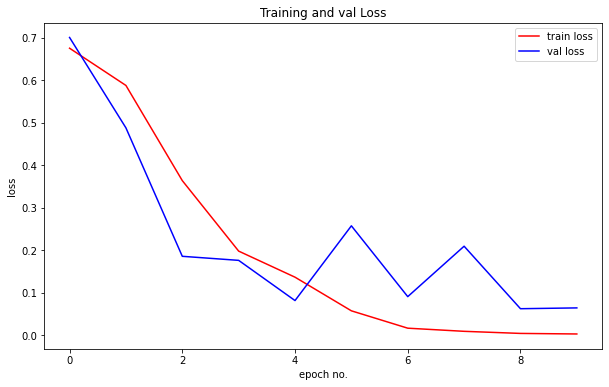

In [226]:
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))

plt.figure
plt.plot(x, epoch_train_loss, color='r', label="train loss")
plt.plot(x, epoch_test_loss, color='b', label="val loss")
plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and val Loss')
plt.show()

## Plot Accuracy

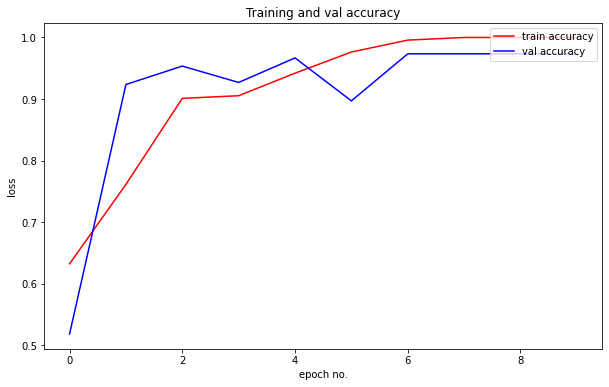

In [227]:
plt.rcParams["figure.figsize"] = (10, 6)
x = range(len(epoch_train_loss))

plt.figure
plt.plot(x, epoch_train_acc, color='r', label="train accuracy")
plt.plot(x, epoch_test_acc, color='b', label="val accuracy")
plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and val accuracy')
plt.show()

## Loading the Model

In [228]:
cnn_model = MyModel()

models = 'models'

model_file_name = 'face_cnn_model.pt'

model_path = os.path.join(models, model_file_name)

# loading the model and getting model parameters by using load_state_dict
cnn_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## Model Prediction

In [229]:
def prediction(model, train_config, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(train_config.device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(train_config.device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

## Perform Inference on Sample Images

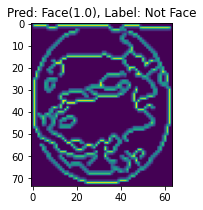

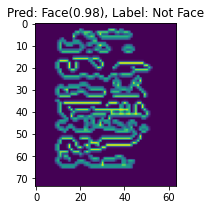

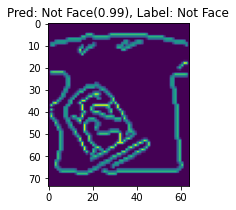

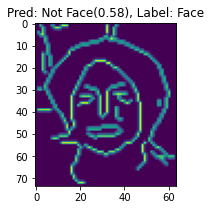

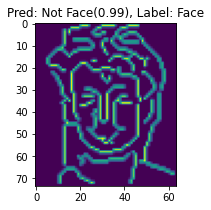

In [230]:
classes = ('Not Face', 'Face')

batch_size = 5
train_config = TrainingConfiguration()

if torch.cuda.is_available():
    train_config.device = "cuda"
else:
    train_config.device = "cpu"

# load testdata with image transformation
transform = transforms.Compose([
    transforms.Resize(64),
    ])

test_loader = torch.utils.data.DataLoader(
    FacesDataset('test', transform),
    batch_size=batch_size,
    shuffle=True,
    )

for data, _ in test_loader:
    # pass the loaded model
    pred, prob = prediction(cnn_model, train_config, data)
    break
    

plt.rcParams["figure.figsize"] = (3, 3)
for images, label in test_loader:
    for i, img in enumerate(images):
        img = transforms.functional.to_pil_image(img)
        plt.imshow(img)
        plt.gca().set_title('Pred: {0}({1:0.2}), Label: {2}'.format(classes[pred[i]], prob[i], classes[label[i]]))
        plt.show()
    break